In [6]:
try:
    already_initialized
except NameError:
    !python -m pip install --upgrade pip
    !pip install spacy==2.3.5
    !python -m spacy download de_core_news_sm
    !pip install tensorflow
    !pip install keras
    already_initialized = True

  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3
     |████████████████████████████████| 10.4 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 69.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 54.0 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 6.2 MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.3.0-py3-none-any.whl size=14907580 sha256=e935ac1bdeb03ee44762096eb62f0264c3d9f2f4dedff4aa434ad06dbbe710c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-r9qex7v7/wheels/fe/44/0f/7270b8ec13bc290e606a3c0f52f981915b1d09d1dfc7c79088
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load th

In [31]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


In [2]:
df = pd.read_json("data/recipes.json")
df.Instructions[2]

'Die Kirschen abtropfen lassen, dabei den Saft auffangen. Das Puddingpulver mit dem Vanillezucker mischen und mit 6 EL Saft glatt rühren. Den übrigen Kirschsaft aufkochen und vom Herd nehmen. Das angerührte Puddingpulver einrühren und unter Rühren ca. eine Minute köcheln. Die Kirschen unter den angedickten Saft geben. Milch, 40 g Zucker, Vanillemark und Butter aufkochen. Den Topf vom Herd ziehen und den Grieß unter Rühren einstreuen. Unter Rühren einmal aufkochen lassen und zugedeckt ca. fünf Minuten quellen lassen.In der Zeit das Ei trennen. Das Eiweiß mit einer Prise Salz steif schlagen und dabei die restlichen 20 g Zucker einrieseln lassen. Das Eigelb unter den Brei rühren und dann das Eiweiß unterheben.Den Grießbrei mit dem Kompott servieren.'

In [3]:
eval_df = df[11000:]
eval_df.shape

(1190, 8)

In [4]:
df = df[:11000]
df.shape

(11000, 8)

In [9]:
nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])
tokenized = [nlp(t) for t in df.Instructions.values]
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

Number of unique tokens: 17556


In [10]:
ingredients = df.Ingredients
ingredients[0]

['600 g Hackfleisch, halb und halb',
 '800 g Sauerkraut',
 '200 g Wurst, geräucherte (Csabai Kolbász)',
 '150 g Speck, durchwachsener, geräucherter',
 '100 g Reis',
 '1 m.-große Zwiebel(n)',
 '1 Zehe/n Knoblauch',
 '2 Becher Schmand',
 '1/2TL Kümmel, ganzer',
 '2 Lorbeerblätter',
 'Salz und Pfeffer',
 '4 Ei(er) (bei Bedarf)',
 'Paprikapulver',
 'etwas Wasser',
 'Öl']

In [11]:
def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.text[0].islower():
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

def _clean(text):
    text = text.replace("(", "")
    text = text.split("/")[0]
    return text

In [12]:
clean = [_clean(t.text) for i in ingredients[214] for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
clean

['Rosenkohl',
 'Schalotte',
 '2Tasse',
 'Hühnerbrühe',
 'Milch',
 'EL',
 'Crème',
 'Speck',
 'Kartoffelgnocchi']

In [13]:
def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels

In [14]:
labels = get_labels(ingredients, tokenized)
set([t.text for t, l in zip(tokenized[214], labels[214]) if l])

{'Crème', 'Hühnerbrühe', 'Milch', 'Rosenkohl', 'Schalotten', 'Speck'}

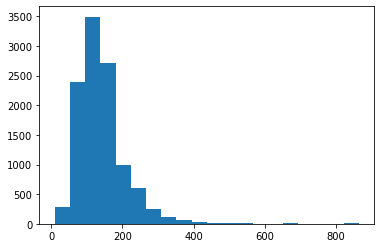

In [15]:
%matplotlib inline

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);

In [17]:
MAX_LEN = 400

In [32]:
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

In [33]:
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)
X_seq[1]

array([192, 193, 194, 183, 195, 196, 128, 197,   9, 198, 199, 200, 201,
       202, 203,  60, 204, 205,   9,  13, 206,  15,  23,  98, 207, 208,
        51, 209,  68, 202, 203,  25,   6, 195, 125, 202, 210, 211, 212,
        33,  45, 213, 214, 100, 196,  13, 215, 216, 217,  33,   9,  68,
       218, 219, 213, 169,  35,  82, 100, 220, 221, 202,   6, 222,  45,
       223,  48, 224,  33,  67, 225, 100, 226,   6, 227, 228, 229, 130,
        45,  92,  85, 230, 211, 231,   6, 232, 233, 234, 235, 145, 157,
       236,   9, 237, 238, 104, 239, 210, 240, 157, 241,  54,   6, 109,
       242, 243, 244, 245, 246, 187, 247,   6, 248, 183, 249, 250,  33,
       129,  13, 251, 252, 101, 253,  33, 254,   9,  31, 255,  40, 172,
         6,   2, 256, 257, 177, 258, 259, 260,  33,  42, 261, 262, 263,
       131, 264, 265, 266,  33, 267,  74, 268, 269,  68, 270,   6,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [34]:
y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

# Setup the network

In [36]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))

model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          877800    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 50)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           129       
Total params: 1,035,625
Trainable params: 1,035,625
Non-trainable params: 0
____________________________________________

In [37]:
history = model.fit(X_seq, y_seq, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
39/39 [==============================] - 156s 4s/step - loss: 0.1688 - accuracy: 0.8801 - val_loss: 0.1040 - val_accuracy: 0.9116
Epoch 2/10
39/39 [==============================] - 136s 3s/step - loss: 0.1032 - accuracy: 0.9112 - val_loss: 0.0914 - val_accuracy: 0.9115
Epoch 3/10
39/39 [==============================] - 135s 3s/step - loss: 0.0879 - accuracy: 0.9113 - val_loss: 0.0624 - val_accuracy: 0.9215
Epoch 4/10
39/39 [==============================] - 135s 3s/step - loss: 0.0467 - accuracy: 0.9482 - val_loss: 0.0250 - val_accuracy: 0.9745
Epoch 5/10
39/39 [==============================] - 177s 5s/step - loss: 0.0238 - accuracy: 0.9749 - val_loss: 0.0235 - val_accuracy: 0.9757
Epoch 6/10
39/39 [==============================] - 469s 12s/step - loss: 0.0225 - accuracy: 0.9763 - val_loss: 0.0228 - val_accuracy: 0.9769
Epoch 7/10
39/39 [==============================] - 448s 12s/step - loss: 0.0213 - accuracy: 0.9779 - val_loss: 0.0221 - val_accuracy: 0.9779
Epoch 8/10


In [ ]:
from datetime import datetime
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'benchmark_model_{now}_loss-{history.history["loss"][-1]:.2f}'
model.save(f'./model/{model_name}')